In [ ]:
from google.colab import files

In [ ]:
import matplotlib.pyplot as plt
# from google.colab import graph.py # Commented out
from graph import *
import requests
import os


# Constante com o valor do PATH do script atual
PATH_PASTA = os.path.dirname(os.path.abspath(__file__))


def download_reactions(entrys, progress, file):
    '''
        Recebe uma lista de enzimas e para cada uma delas realiza o download das
        reacoes catalisadas por ela, escrevendo o resultado em um arquivo a medida
        que as consultas sao realizada. Caso uma enzima nao possua nenhuma reacao
        atribuida a ela na API do Kegg, ela nao sera escrita no arquivo resultante.

        :param entrys: list: lista contendo entradas para as enzimas (str)
        :param progress: bool: se True, escreve o progresso da busca na tela
        :param file: str: path/nome do arquivo a ser salvo
    '''
    num_enzs = len(entrys)
    if progress:
        print('\nAndamento do processo (%):')
    for cont, enz in enumerate(entrys):
        seach_rns = requests.get(f'https://rest.kegg.jp/link/reaction/{enz}')
        # Algumas enzimas não possuem reações associados a elas na database
        reactions = list(rn for rn in seach_rns.text.split() if 'rn' in rn)
        if progress:
            print(f'Request {cont+1} of {num_enzs}: ({100*((cont+1)/num_enzs):.2f}%) complete')
        # Se a enzima não possui reações associadas, a lista será vazia, logo False
        if reactions:
            with open(file, 'a') as fp:
                fp.write(f'{enz}')
                for rn in reactions:
                    fp.write(f',{rn}')
                fp.write('\n')


def download_compounds(entrys, progress, file):
    '''
        Recebe uma lista de reacoes e para cada uma delas realiza o download das
        dos dados da reacao: nome da enzima e compostos envolvidos nela, salvando
        o resultado em um arquivo a medida que as consultas sao realizadas.

        :param entrys: list: lista contendo entradas para as reacoes (str)
        :param progress: bool: se True, escreve o progresso da busca na tela
        :param file: str: path/nome do arquivo a ser salvo
    '''
    num_reac = len(entrys)
    if progress:
        print('\nAndamento do processo (%):')
    for cont, rn in enumerate(entrys):
        seach_comps = requests.get(f'https://rest.kegg.jp/link/compound/{rn}')
        # Algumas reações não possuem compostos associados a elas na database
        compounds = list(cp for cp in seach_comps.text.split() if 'cpd' in cp)
        if progress:
            print(f'Request {cont+1} of {num_reac}: ({100*((cont+1)/num_reac):.2f}%) complete')
        # Se a reação não possui compostos associados, a lista será vazia, logo False
        if compounds:
            with open(file, 'a') as fp:
                fp.write(f'{rn}')
                for comp in compounds:
                    fp.write(f',{comp}')
                fp.write('\n')


def get_reactions(enzymes=None, verbose=True, overwrite=False, name_file=None):
    '''
        Retorna uma lista contendo as reacoes catalisadas por todas as enzimas
        dadas. Deve-se fornecer a lista de enzimas para procurar na API do
        Kegg ou o nome do arquivo .csv contendo cada enzima e suas reacoes.
        Se o arquivo dado nao existe, mas for dada a lista de enzimas, sera
        realizada a escrita do arquivo.

        :param enzymes: list: lista contendo entradas para as enzimas (str).
                              Necessario se arquivo nao for dado ou nao existir.
        :param verbose: bool: se True, escreve o progresso da busca na tela se
                              esta for realizada.
        :param overwrite: bool: se True, realiza uma nova busca obrigatoriamente e
                                sobreescreve o arquivo dado se ele existir
        :param name_file: str: path/nome do arquivo a ser lido ou escrito
        :return list: lista contendo todas as reacoes catalisadas por todas as enzimas
    '''
    if not name_file:
        name_file = f'{PATH_PASTA}/EnzymesReactions.csv'
    file_exists = os.path.isfile(name_file)
    if enzymes and (not file_exists or overwrite):
        if file_exists:
            os.remove(name_file)
        download_reactions(enzymes, progress=verbose, file=name_file)
    with open(name_file) as fp:
        data_file = fp.readlines()
        for pos, lin in enumerate(data_file):
            data_file[pos] = lin.replace('\n','').split(sep=',')
    reactions = list()
    for item in data_file:
        reactions.extend(item[1:])
    return reactions


def get_groups_compounds(reactions=None, verbose=True, overwrite=False, name_file=None):
    '''
        Retorna uma lista de listas, que representam os compostos envolvidos em
        uma reação química e que, por tanto, estao relacionados entre si.

        :param reactions: list: lista contendo entradas para as reacoes (str).
                              Necessario se arquivo nao for dado ou nao existir.
        :param verbose: bool: se True, escreve o progresso da busca na tela se
                              esta for realizada.
        :param overwrite: bool: se True, realiza uma nova busca obrigatoriamente e
                                sobreescreve o arquivo dado se ele existir
        :param name_file: str: path/nome do arquivo a ser lido ou escrito
        :return list: lista contendo listas onde estao juntos todos os compostos
                      envolvidos em uma reacao quimica
    '''
    if not name_file:
        name_file = f'{PATH_PASTA}/ReactionsCompounds.csv'
    file_exists = os.path.isfile(name_file)
    if reactions and (not file_exists or overwrite):
        if file_exists:
            os.remove(name_file)
        download_compounds(reactions, progress=verbose, file=name_file)
    with open(name_file) as fp:
        data_file = fp.readlines()
        for pos, lin in enumerate(data_file):
            data_file[pos] = lin.replace('\n','').split(sep=',')
    return list(lin[1:] for lin in data_file)


def get_pairs_distinct(group):
    '''
        Recebe um grupo de strings (iterable) e retorna um gerador com
        todas as combinacoes de strings distintas para o grupo.

        :param group: iterable: iterable contendo as strings a serem combinadas
        :return generator: tuplas contendo as combinações de strings distintas
    '''
    return ((str1, str2) for str2 in group for str1 in group if str1 != str2)


if __name__ == '__main__':

    # Para ver os comandos da API do Kegg deve-se usar os comandos
    # presentes em http://www.kegg.jp/kegg/rest/keggapi.html

    # Base da API do Kegg
    base_url = "https://rest.kegg.jp/"

    # Faz o dowload dos dados da página
    list_organisms = requests.get(f'{base_url}/list/organism')

    # Texto com as informações de cada organismo
    data = list_organisms.text
    print(data)

    # Código do organismo que eu escolhi (Gemmata obscuriglobus)
    cod_kegg = 'plj'

    # Apenas se o arquivo não existir ainda, realiza a busca por ele
    if not os.path.isfile(f'{PATH_PASTA}/ReactionsCompounds.csv'):

        # Obtem todas as enzimas associadas a um organismo
        search_enzymes = requests.get(f'{base_url}/link/enzyme/{cod_kegg}')
        print(search_enzymes.text)

        # Cria uma lista com todas as enzimas do organismo
        enzymes_gog = list(enz for enz in search_enzymes.text.split() if 'ec' in enz)

        # Para cada enzima realiza o download de todas as reações catalisadas pela enzima
        data_reactions = get_reactions(enzymes_gog)

    # Como cada consulta por cada enzima demora muito, eu programei a função get_reactions
    # para salvar todas elas em um arquivo para fazer isso apenas uma vez (se o arquivo
    # 'EnzymesReactions.csv' já existir, a função pega as reações diretamente dele, se não
    # os requests sao realizados). Abaixo, os dados sao pegos diretamente do arquivo se ele
    # existir (não é necessário dar o nome do arquivo, pois esse já é padrão, coloquei apenas
    # para facilitar o entendimento)
    else:
        data_reactions = get_reactions(name_file=f'{PATH_PASTA}/ReactionsCompounds.csv')

    # Realiza o print de todas as reações do organismo
    print(f'\n{len(data_reactions):<8} reações registradas para o organismo Gemmata obscuriglobus')

    # Para cada reacao, realiza o download de seus compostos e escreve o arquivo
    # O que a função get_groups_compounds retorna é uma lista de lista contendo os
    # códigos KEGG de cada composto consumido ou produzido na reação quimica. Cada
    # um desses grupos esta conectado entre si, porém outras reações podem utilizar
    # os mesmos compostos, então um mesmo composto pode participar de várias reações
    related_compounds = get_groups_compounds(data_reactions)

    # Vou obter os IDs de cada composto uma única vez para evitar redundância, para isso
    # armazeno todos os IDs em um set, pois este não permite valores duplicados. Depois,
    # para cada ID atribuo um valor numérico que indica o seu index na matriz, ou seja,
    # a linha/coluna com aquele index representa aquele ID em específico. Para isso,
    # transformo o set de IDs em um dicionário onde o ID é a chave e seu index, o valor.
    ids_compounds = set()
    for group in related_compounds:
        ids_compounds.update(group)
    ids_compounds = {k: index for index, k in enumerate(ids_compounds)}

    # Crio uma matriz simétrica de dimensões NxN, onde N é o número de compostos que
    # temos, preenchendo 0 como valor padrão (ou seja, não há conexões para o grafo).
    matriz = [[0] * len(ids_compounds) for j in range(len(ids_compounds))]

    # Para cada grupo de compostos relacionados por uma reação química, gero todos os
    # pares de combinações distintas do grafo. Por conveniênica, não considerei a ordem
    # reagentes->produtos, então nosso grafo é não-direcionado (não é uma aproximação
    # ruim, pois muitas reações químicas em meio biológico são de fato reversíveis)
    graph_edges = set()
    for reaction in related_compounds:
        graph_edges.update(get_pairs_distinct(reaction))

    # Para cada par de compostos relacionados, ligo os nós na rede
    for comp1, comp2 in graph_edges:
        matriz[ids_compounds[comp1]][ids_compounds[comp2]] = 1

    # Faz print do número de vértices e arestas da rede
    nVertex = len(ids_compounds)
    print(f'{nVertex:<8} compostos registrados para o organismo (Nós da rede)')
    del ids_compounds, graph_edges, related_compounds

    # Exibe as estatísticas da rede
    print('\nEstatísticas da rede metabólica:\n')
    kis = [sum(lin) for lin in matriz]
    nlinks = sum(kis) / 2
    cs = clustering(matriz)         # Calcula o coeficiente de clustering local para cada nó
    mcs = sum(cs) / nVertex         # Calcula o coeficiente de clustering médio da rede
    ass = assortativity(matriz)     # Calcula a assortatividade e plota o gráfico de dispersão desta
    # Coef. de clustering do grafo corresponde a média dos coef. de clustering local de cada vértice
    print(f'\tCoeficiente de clustering: {mcs:.2f}')
    print(f'\tAssortatividade: {ass:.2f}')
    print(f'\tLinks esperados: {0.5 * mcs * nVertex * (nVertex - 1):.2f}')
    print(f'\tLinks obtidos: {nlinks}')

    # Plota a rede metabólica
    plot_graph(matriz, R=10, tk=0.01)

    # Histograma dos graus da rede metabólicas
    metNetwork, metLen = kis, len(set(kis))
    plt.hist(metNetwork, bins=metLen, color='orange')
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Distribuição dos graus dos nós na rede metabólica')
    plt.yscale('symlog') # Põe o eixo y em escala logarítmica, pois alguns nós tem grau muito elevado
    plt.show()

    # --------------------------------------------------------------------------------------------------
    # Criação de um rede aleatória
    # --------------------------------------------------------------------------------------------------
    print('\nEstatísticas da rede aleatória:\n')
    matriz = rand_graph(nVertex, mcs)
    kis = [sum(lin) for lin in matriz]
    nlinks = sum(kis) / 2
    cs = clustering(matriz)  # Demorou alguns minutos para calcular o clustering da rede aleatória
    mcs = sum(cs) / nVertex
    ass = assortativity(matriz)
    print(f'\tCoeficiente de clustering: {mcs:.2f}')
    print(f'\tAssortatividade: {ass:.2f}')
    print(f'\tLinks esperados: {0.5 * mcs * nVertex * (nVertex - 1):.2f}')
    print(f'\tLinks obtidos: {nlinks}\n')

    # Não consegui plotar a rede aleatória, meu PC travou...

    # Histograma dos graus da rede aleatória
    plt.hist(kis, bins=len(set(kis)))
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Distribuição dos graus dos nós na rede aletória')
    plt.show()

    # Histograma dos graus da rede aleatória em relação à rede metabólica
    plt.hist(kis, bins=len(set(kis)))
    plt.hist(metNetwork, bins=metLen, color='orange')
    plt.legend(('Rede aleatória', 'Rede metabólica'))
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Rede metabólica x Rede Aleatória')
    plt.show()


NameError: name 'stop' is not defined

In [ ]:
!pip install networkx


A saída de streaming foi truncada nas últimas 5000 linhas.
Request 1802 of 1931: (93.32%) complete
Request 1803 of 1931: (93.37%) complete
Request 1804 of 1931: (93.42%) complete
Request 1805 of 1931: (93.47%) complete
Request 1806 of 1931: (93.53%) complete
Request 1807 of 1931: (93.58%) complete
Request 1808 of 1931: (93.63%) complete
Request 1809 of 1931: (93.68%) complete
Request 1810 of 1931: (93.73%) complete
Request 1811 of 1931: (93.79%) complete
Request 1812 of 1931: (93.84%) complete
Request 1813 of 1931: (93.89%) complete
Request 1814 of 1931: (93.94%) complete
Request 1815 of 1931: (93.99%) complete
Request 1816 of 1931: (94.04%) complete
Request 1817 of 1931: (94.10%) complete
Request 1818 of 1931: (94.15%) complete
Request 1819 of 1931: (94.20%) complete
Request 1820 of 1931: (94.25%) complete
Request 1821 of 1931: (94.30%) complete
Request 1822 of 1931: (94.36%) complete
Request 1823 of 1931: (94.41%) complete
Request 1824 of 1931: (94.46%) complete
Request 1825 of 1931:

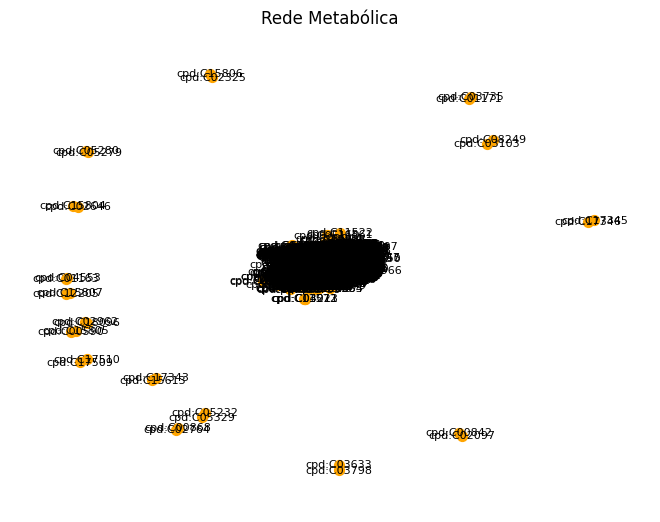

TypeError: cannot unpack non-iterable int object

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import requests
import os
import networkx as nx


# Constante com o valor do PATH do script atual
PATH_PASTA = '/content'

def download_reactions(entrys, progress, file):
    num_enzs = len(entrys)
    if progress:
        print('\nAndamento do processo (%):')
    for cont, enz in enumerate(entrys):
        seach_rns = requests.get(f'https://rest.kegg.jp/link/reaction/{enz}')
        reactions = list(rn for rn in seach_rns.text.split() if 'rn' in rn)
        if progress:
            print(f'Request {cont+1} of {num_enzs}: ({100*((cont+1)/num_enzs):.2f}%) complete')
        if reactions:
            with open(file, 'a') as fp:
                fp.write(f'{enz}')
                for rn in reactions:
                    fp.write(f',{rn}')
                fp.write('\n')

def download_compounds(entrys, progress, file):
    num_reac = len(entrys)
    if progress:
        print('\nAndamento do processo (%):')
    for cont, rn in enumerate(entrys):
        seach_comps = requests.get(f'https://rest.kegg.jp/link/compound/{rn}')
        compounds = list(cp for cp in seach_comps.text.split() if 'cpd' in cp)
        if progress:
            print(f'Request {cont+1} of {num_reac}: ({100*((cont+1)/num_reac):.2f}%) complete')
        if compounds:
            with open(file, 'a') as fp:
                fp.write(f'{rn}')
                for comp in compounds:
                    fp.write(f',{comp}')
                fp.write('\n')

def get_reactions(enzymes=None, verbose=True, overwrite=False, name_file=None):
    if not name_file:
        name_file = f'{PATH_PASTA}/EnzymesReactions.csv'
    file_exists = os.path.isfile(name_file)
    if enzymes and (not file_exists or overwrite):
        if file_exists:
            os.remove(name_file)
        download_reactions(enzymes, progress=verbose, file=name_file)
    with open(name_file) as fp:
        data_file = fp.readlines()
        for pos, lin in enumerate(data_file):
            data_file[pos] = lin.replace('\n','').split(sep=',')
    reactions = list()
    for item in data_file:
        reactions.extend(item[1:])
    return reactions

def get_groups_compounds(reactions=None, verbose=True, overwrite=False, name_file=None):
    if not name_file:
        name_file = f'{PATH_PASTA}/ReactionsCompounds.csv'
    file_exists = os.path.isfile(name_file)
    if reactions and (not file_exists or overwrite):
        if file_exists:
            os.remove(name_file)
        download_compounds(reactions, progress=verbose, file=name_file)
    with open(name_file) as fp:
        data_file = fp.readlines()
        for pos, lin in enumerate(data_file):
            data_file[pos] = lin.replace('\n','').split(sep=',')
    return list(lin[1:] for lin in data_file)

def create_graph_from_compounds(compounds_groups):
    G = nx.Graph()
    for group in compounds_groups:
        G.add_edges_from([(str1, str2) for str2 in group for str1 in group if str1 != str2])
    return G

def calculate_statistics(G):
    stats = {}
    stats['clustering'] = nx.average_clustering(G)
    stats['assortativity'] = nx.degree_assortativity_coefficient(G)
    stats['expected_links'] = 0.5 * stats['clustering'] * G.number_of_nodes() * (G.number_of_nodes() - 1)
    stats['actual_links'] = G.number_of_edges()
    return stats

if __name__ == '__main__':
    # Base da API do Kegg
    base_url = "https://rest.kegg.jp/"

    # Faz o dowload dos dados da página
    list_organisms = requests.get(f'{base_url}/list/organism')

    # Texto com as informações de cada organismo
    data = list_organisms.text
    print(data)

    # Código do organismo que eu escolhi (Gemmata obscuriglobus)
    cod_kegg = 'plj'

    if not os.path.isfile(f'{PATH_PASTA}/ReactionsCompounds.csv'):
        search_enzymes = requests.get(f'{base_url}/link/enzyme/{cod_kegg}')
        enzymes_gog = list(enz for enz in search_enzymes.text.split() if 'ec' in enz)
        data_reactions = get_reactions(enzymes_gog)
    else:
        data_reactions = get_reactions(name_file=f'{PATH_PASTA}/ReactionsCompounds.csv')

    print(f'\n{len(data_reactions):<8} reações registradas para o organismo')
    related_compounds = get_groups_compounds(data_reactions)

    G = create_graph_from_compounds(related_compounds)

    print(f'{G.number_of_nodes():<8} compostos registrados para o organismo (Nós da rede)')

    # Exibe as estatísticas da rede
    stats = calculate_statistics(G)
    print('\nEstatísticas da rede metabólica:\n')
    print(f'\tCoeficiente de clustering: {stats["clustering"]:.2f}')
    print(f'\tAssortatividade: {stats["assortativity"]:.2f}')
    print(f'\tLinks esperados: {stats["expected_links"]:.2f}')
    print(f'\tLinks obtidos: {stats["actual_links"]}')

    # Plota a rede metabólica
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=50, node_color='orange', font_size=8, font_color='black')
    plt.title('Rede Metabólica')
    plt.show()

    # Histograma dos graus da rede metabólica
    degree_sequence = [G.degree(n) for n in G.nodes()]
    plt.hist([d for n, d in degree_sequence], bins=range(max(d for n, d in degree_sequence) + 1), color='orange')
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Distribuição dos graus dos nós na rede metabólica')
    plt.yscale('symlog')
    plt.show()

    # Criação de uma rede aleatória
    G_random = nx.erdos_renyi_graph(G.number_of_nodes(), stats['clustering'] / (G.number_of_nodes() - 1))
    stats_random = calculate_statistics(G_random)

    print('\nEstatísticas da rede aleatória:\n')
    print(f'\tCoeficiente de clustering: {stats_random["clustering"]:.2f}')
    print(f'\tAssortatividade: {stats_random["assortativity"]:.2f}')
    print(f'\tLinks esperados: {stats_random["expected_links"]:.2f}')
    print(f'\tLinks obtidos: {stats_random["actual_links"]}\n')

    # Plota a rede aleatória
    pos_random = nx.spring_layout(G_random)
    nx.draw(G_random, pos_random, with_labels=True, node_size=50, node_color='cyan', font_size=8, font_color='black')
    plt.title('Rede Aleatória')
    plt.show()

    # Histograma dos graus da rede aleatória
    degree_sequence_random = [G_random.degree(n) for n in G_random.nodes()]
    plt.hist([d for n, d in degree_sequence_random], bins=range(max(d for n, d in degree_sequence_random) + 1))
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Distribuição dos graus dos nós na rede aleatória')
    plt.show()

    # Comparar histograma dos graus da rede aleatória com a rede metabólica
    plt.hist([d for n, d in degree_sequence_random], bins=range(max(d for n, d in degree_sequence_random) + 1), alpha=0.5, label='Rede Aleatória')
    plt.hist([d for n, d in degree_sequence], bins=range(max(d for n, d in degree_sequence) + 1), color='orange', alpha=0.5, label='Rede Metabólica')
    plt.legend()
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Rede Metabólica vs Rede Aleatória')
    plt.show()



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import requests
import os

# Constante com o valor do PATH do script atual
PATH_PASTA = '/content'

def download_reactions(entrys, progress, file):
    num_enzs = len(entrys)
    if progress:
        print('\nAndamento do processo (%):')
    for cont, enz in enumerate(entrys):
        seach_rns = requests.get(f'https://rest.kegg.jp/link/reaction/{enz}')
        reactions = list(rn for rn in seach_rns.text.split() if 'rn' in rn)
        if progress:
            print(f'Request {cont+1} of {num_enzs}: ({100*((cont+1)/num_enzs):.2f}%) complete')
        if reactions:
            with open(file, 'a') as fp:
                fp.write(f'{enz}')
                for rn in reactions:
                    fp.write(f',{rn}')
                fp.write('\n')

def download_compounds(entrys, progress, file):
    num_reac = len(entrys)
    if progress:
        print('\nAndamento do processo (%):')
    for cont, rn in enumerate(entrys):
        seach_comps = requests.get(f'https://rest.kegg.jp/link/compound/{rn}')
        compounds = list(cp for cp in seach_comps.text.split() if 'cpd' in cp)
        if progress:
            print(f'Request {cont+1} of {num_reac}: ({100*((cont+1)/num_reac):.2f}%) complete')
        if compounds:
            with open(file, 'a') as fp:
                fp.write(f'{rn}')
                for comp in compounds:
                    fp.write(f',{comp}')
                fp.write('\n')

def get_reactions(enzymes=None, verbose=True, overwrite=False, name_file=None):
    if not name_file:
        name_file = f'{PATH_PASTA}/EnzymesReactions.csv'
    file_exists = os.path.isfile(name_file)
    if enzymes and (not file_exists or overwrite):
        if file_exists:
            os.remove(name_file)
        download_reactions(enzymes, progress=verbose, file=name_file)
    with open(name_file) as fp:
        data_file = fp.readlines()
        for pos, lin in enumerate(data_file):
            data_file[pos] = lin.replace('\n','').split(sep=',')
    reactions = list()
    for item in data_file:
        reactions.extend(item[1:])
    return reactions

def get_groups_compounds(reactions=None, verbose=True, overwrite=False, name_file=None):
    if not name_file:
        name_file = f'{PATH_PASTA}/ReactionsCompounds.csv'
    file_exists = os.path.isfile(name_file)
    if reactions and (not file_exists or overwrite):
        if file_exists:
            os.remove(name_file)
        download_compounds(reactions, progress=verbose, file=name_file)
    with open(name_file) as fp:
        data_file = fp.readlines()
        for pos, lin in enumerate(data_file):
            data_file[pos] = lin.replace('\n','').split(sep=',')
    return list(lin[1:] for lin in data_file)

def create_graph_from_compounds(compounds_groups):
    G = nx.Graph()
    for group in compounds_groups:
        G.add_edges_from([(str1, str2) for str2 in group for str1 in group if str1 != str2])
    return G

def calculate_statistics(G):
    stats = {}
    stats['clustering'] = nx.average_clustering(G)
    stats['assortativity'] = nx.degree_assortativity_coefficient(G)
    stats['expected_links'] = 0.5 * stats['clustering'] * G.number_of_nodes() * (G.number_of_nodes() - 1)
    stats['actual_links'] = G.number_of_edges()
    return stats

if __name__ == '__main__':
    # Base da API do Kegg
    base_url = "https://rest.kegg.jp/"

    # Faz o dowload dos dados da página
    list_organisms = requests.get(f'{base_url}/list/organism')

    # Texto com as informações de cada organismo
    data = list_organisms.text
    print(data)

    # Código do organismo que eu escolhi (Gemmata obscuriglobus)
    cod_kegg = 'plj'

    if not os.path.isfile(f'{PATH_PASTA}/ReactionsCompounds.csv'):
        search_enzymes = requests.get(f'{base_url}/link/enzyme/{cod_kegg}')
        enzymes_gog = list(enz for enz in search_enzymes.text.split() if 'ec' in enz)
        data_reactions = get_reactions(enzymes_gog)
    else:
        data_reactions = get_reactions(name_file=f'{PATH_PASTA}/ReactionsCompounds.csv')

    print(f'\n{len(data_reactions):<8} reações registradas para o organismo Gemmata obscuriglobus')
    related_compounds = get_groups_compounds(data_reactions)

    G = create_graph_from_compounds(related_compounds)

    print(f'{G.number_of_nodes():<8} compostos registrados para o organismo (Nós da rede)')

    # Exibe as estatísticas da rede
    stats = calculate_statistics(G)
    print('\nEstatísticas da rede metabólica:\n')
    print(f'\tCoeficiente de clustering: {stats["clustering"]:.2f}')
    print(f'\tAssortatividade: {stats["assortativity"]:.2f}')
    print(f'\tLinks esperados: {stats["expected_links"]:.2f}')
    print(f'\tLinks obtidos: {stats["actual_links"]}')

    # Plota a rede metabólica
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=50, node_color='orange', font_size=8, font_color='black')
    plt.title('Rede Metabólica')
    plt.show()

    # Histograma dos graus da rede metabólica
    degree_sequence = [d for n, d in G.degree()]
    plt.hist(degree_sequence, bins=range(max(degree_sequence) + 1), color='orange')
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Distribuição dos graus dos nós na rede metabólica')
    plt.yscale('symlog')
    plt.show()

    # Criação de uma rede aleatória
    G_random = nx.erdos_renyi_graph(G.number_of_nodes(), stats['clustering'] / (G.number_of_nodes() - 1))
    stats_random = calculate_statistics(G_random)

    print('\nEstatísticas da rede aleatória:\n')
    print(f'\tCoeficiente de clustering: {stats_random["clustering"]:.2f}')
    print(f'\tAssortatividade: {stats_random["assortativity"]:.2f}')
    print(f'\tLinks esperados: {stats_random["expected_links"]:.2f}')
    print(f'\tLinks obtidos: {stats_random["actual_links"]}\n')

    # Plota a rede aleatória
    pos_random = nx.spring_layout(G_random)
    nx.draw(G_random, pos_random, with_labels=True, node_size=50, node_color='cyan', font_size=8, font_color='black')
    plt.title('Rede Aleatória')
    plt.show()

    # Histograma dos graus da rede aleatória
    degree_sequence_random = [d for n, d in G_random.degree()]
    plt.hist(degree_sequence_random, bins=range(max(degree_sequence_random) + 1))
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Distribuição dos graus dos nós na rede aleatória')
    plt.show()

    # Comparar histograma dos graus da rede aleatória com a rede metabólica
    plt.hist(degree_sequence_random, bins=range(max(degree_sequence_random) + 1), alpha=0.5, label='Rede Aleatória')
    plt.hist(degree_sequence, bins=range(max(degree_sequence) + 1), color='orange', alpha=0.5, label='Rede Metabólica')
    plt.legend()
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Rede Metabólica vs Rede Aleatória')
    plt.show()


A saída de streaming foi truncada nas últimas 5000 linhas.
T08735	baer	Bacillus aerophilus	Prokaryotes;Bacteria;Bacilli;Bacillus
T05386	bsaf	Bacillus safensis	Prokaryotes;Bacteria;Bacilli;Bacillus
T06767	bfd	Bacillus freudenreichii	Prokaryotes;Bacteria;Bacilli;Bacillus
T07881	bshi	Bacillus shivajii	Prokaryotes;Bacteria;Bacilli;Bacillus
T07942	bbad	Bacillus badius	Prokaryotes;Bacteria;Bacilli;Bacillus
T08101	bcab	Bacillus cabrialesii	Prokaryotes;Bacteria;Bacilli;Bacillus
T08218	bry	Bacillus rugosus	Prokaryotes;Bacteria;Bacilli;Bacillus
T02027	bjs	Bacillus sp. JS	Prokaryotes;Bacteria;Bacilli;Bacillus
T02643	baci	Bacillus sp. 1NLA3E	Prokaryotes;Bacteria;Bacilli;Bacillus
T03242	gst	Bacillus sp. X1(2014)	Prokaryotes;Bacteria;Bacilli;Bacillus
T03530	bacw	Bacillus sp. WP8	Prokaryotes;Bacteria;Bacilli;Bacillus
T03544	bacp	Bacillus sp. Pc3	Prokaryotes;Bacteria;Bacilli;Bacillus
T03582	bacb	Bacillus sp. BH072	Prokaryotes;Bacteria;Bacilli;Bacillus
T03635	baco	Bacillus sp. OxB-1	Prokaryotes;Bacteri

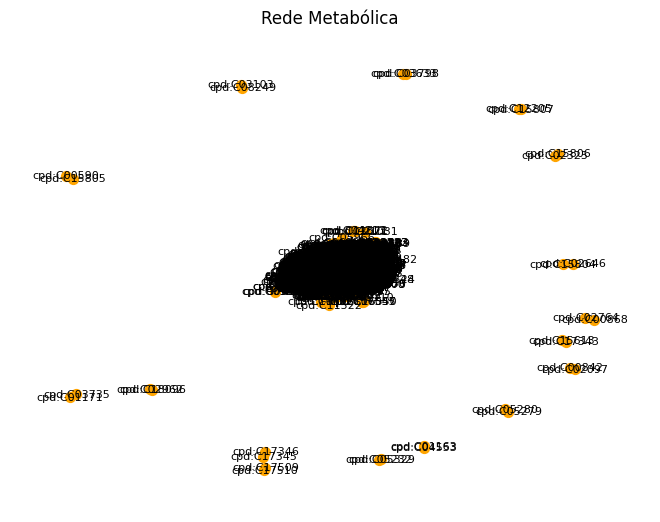

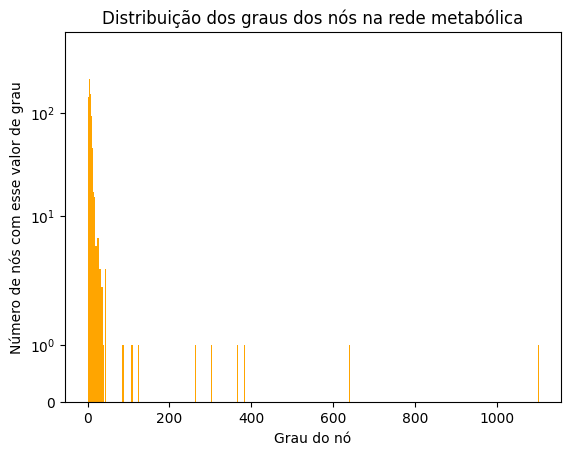


Estatísticas da rede aleatória:

	Coeficiente de clustering: 0.00
	Assortatividade: 0.02
	Links esperados: 5814.00
	Links obtidos: 775



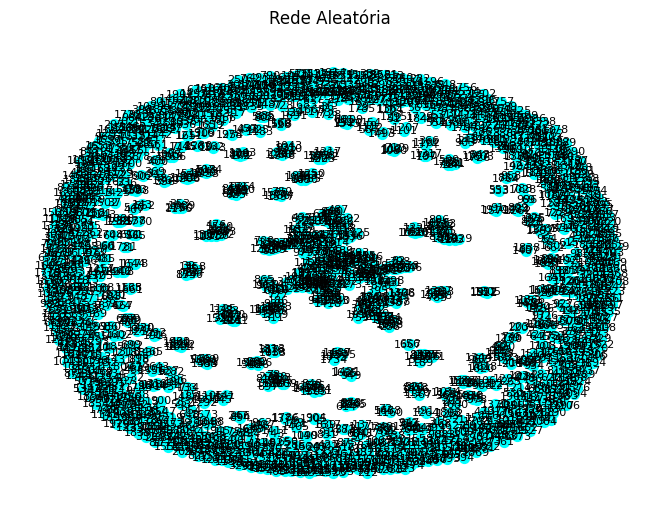

In [ ]:
if __name__ == '__main__':
    # Base da API do Kegg
    base_url = "https://rest.kegg.jp/"

    # Faz o dowload dos dados da página
    list_organisms = requests.get(f'{base_url}/list/organism')

    # Texto com as informações de cada organismo
    data = list_organisms.text
    print(data)

    # Código do organismo que eu escolhi (Gemmata obscuriglobus)
    cod_kegg = 'plj'

    # The following lines were commented out and may be the source of the error
    #if not os.path.isfile(f'{PATH_PASTA}/ReactionsCompounds.csv'):
    #    search_enzymes = requests.get(f'{base_url}/link/enzyme/{cod_kegg}')
    #    enzymes_gog = list(enz for enz in search_enzymes.text.split() if 'ec' in enz)
    #    data_reactions = get_reactions(enzymes_gog)
    #else:

    data_reactions = get_reactions(name_file=f'{PATH_PASTA}/ReactionsCompounds.csv')

    print(f'\n{len(data_reactions):<8} reações registradas para o organismo')
    related_compounds = get_groups_compounds(data_reactions)

    G = create_graph_from_compounds(related_compounds)

    # This line was incorrectly indented
    print(f'{G.number_of_nodes():<8} compostos registrados para o organismo (Nós da rede)')

    # Exibe as estatísticas da rede
    stats = calculate_statistics(G)
    print('\nEstatísticas da rede metabólica:\n')
    print(f'\tCoeficiente de clustering: {stats["clustering"]:.2f}')
    print(f'\tAssortatividade: {stats["assortativity"]:.2f}')
    print(f'\tLinks esperados: {stats["expected_links"]:.2f}')
    print(f'\tLinks obtidos: {stats["actual_links"]}')

    # Plota a rede metabólica
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=50, node_color='orange', font_size=8, font_color='black')
    plt.title('Rede Metabólica')
    plt.show()

    # Histograma dos graus da rede metabólica
    degree_sequence = [d for n, d in G.degree()]
    plt.hist(degree_sequence, bins=range(max(degree_sequence) + 1), color='orange')
    plt.ylabel('Número de nós com esse valor de grau')
    plt.xlabel('Grau do nó')
    plt.title('Distribuição dos graus dos nós na rede metabólica')
    plt.yscale('symlog')
    plt.show()

    # Criação de uma rede aleatória
    G_random = nx.erdos_renyi_graph(G.number_of_nodes(), stats['clustering'] / (G.number_of_nodes() - 1))
    stats_random = calculate_statistics(G_random)

    print('\nEstatísticas da rede aleatória:\n')
    print(f'\tCoeficiente de clustering: {stats_random["clustering"]:.2f}')
    print(f'\tAssortatividade: {stats_random["assortativity"]:.2f}')
    print(f'\tLinks esperados: {stats_random["expected_links"]:.2f}')
    print(f'\tLinks obtidos: {stats_random["actual_links"]}\n')

    # Plota a rede aleatória
    pos_random = nx.spring_layout(G_random)
    nx.draw(G_random, pos_random, with_labels=True, node_size=50, node_color='cyan', font_size=8, font_color='black')
    plt.title('Rede Aleatória')
    plt